<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/w1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1주차] 심화과제: MNIST 예측 모델에 deep learning techniques 적용하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

Dataset을 MNIST에서 CIFAR10으로 변경

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:02<00:00, 70.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

## [MY CODE] 3채널 이미지 확인

CIFAR10 이미지는 (channel, height, width) 형식인데 반해, plt.imshow는 (height, width, channel)을 인자로 받기 때문에, permute를 이용해서 순서를 재배열

50000
torch.Size([3, 32, 32]) 6


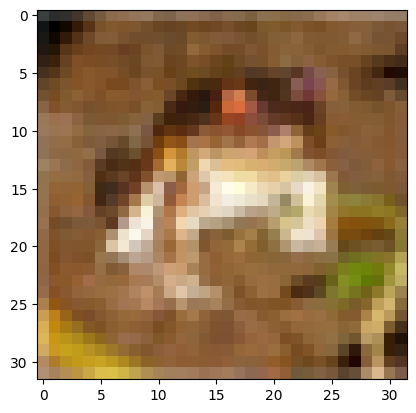

In [3]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0].permute(1, 2, 0))

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified


In [6]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
)

In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


## [LOG] shape 확인

In [8]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


adam_model = Model(32 * 32 * 3, 1024)
sgd_model = Model(32 * 32 * 3, 1024)

## [FEEDBACK] 왜 여기선 LeackyReLU를 쓰나요?

leackyReLU가 음수를 0으로 만들지 않아서, 음수에 대해서도 학습이 가능하다는 것은 알겠는데, 여기서는 왜 음수에 대해서 학습하는 것이 중요한지 모르겠습니다.

## [MY CODE] Adam optimizer 사용

In [9]:
from torch.optim import Adam, SGD


lr = 0.001
adam_model = adam_model.to('cuda')
sgd_model = sgd_model.to('cuda')

sgd_optimizer = SGD(sgd_model.parameters(), lr=lr)
adam_optimizer = Adam(adam_model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [10]:
def accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    cnt = 0
    acc = 0

    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=1)

      cnt += labels.shape[0]
      acc += (preds == labels).sum().item()

    return acc / cnt

## [MY CODE] Adam 학습 및 정확도 계산

In [11]:
n_epochs = 50
adam_train_acc_list = []
sgd_train_acc_list = []

for epoch in range(n_epochs):
  adam_total_loss = 0
  sgd_total_loss = 0

  for data in trainloader:
    adam_model.zero_grad()
    sgd_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    adam_preds = adam_model(inputs)
    adam_loss = criterion(adam_preds, labels)
    adam_loss.backward()
    adam_optimizer.step()

    adam_total_loss += adam_loss.item()

    sgd_preds = sgd_model(inputs)
    sgd_loss = criterion(sgd_preds, labels)
    sgd_loss.backward()
    sgd_optimizer.step()

    sgd_total_loss += sgd_loss.item()


  # Append Accuracies
  adam_train_acc_list.append(accuracy(adam_model, trainloader))
  sgd_train_acc_list.append(accuracy(sgd_model, testloader))


  if epoch % 10 == 0:
    print(f"[Adam] Epoch {epoch:3d} | Loss: {adam_total_loss:.3f}")
    print(f"[SGD] Epoch {epoch:3d} | Loss: {sgd_total_loss:.3f}")

[Adam] Epoch   0 | Loss: 366.789
[SGD] Epoch   0 | Loss: 450.463
[Adam] Epoch  10 | Loss: 245.610
[SGD] Epoch  10 | Loss: 428.747
[Adam] Epoch  20 | Loss: 193.546
[SGD] Epoch  20 | Loss: 402.508
[Adam] Epoch  30 | Loss: 142.442
[SGD] Epoch  30 | Loss: 386.583
[Adam] Epoch  40 | Loss: 96.571
[SGD] Epoch  40 | Loss: 376.541


## [LOG] 학습 과정에서 Epoch별 손실값 출력

In [12]:
def plot_acc(accs1, accs2, label1='sgd', label2='adam'):
  x = np.arange(len(accs1))

  plt.plot(x, accs1, label=label1)
  plt.plot(x, accs2, label=label2)
  plt.legend()
  plt.show()

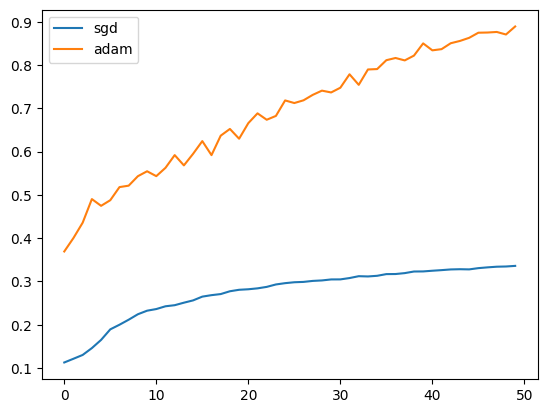

In [13]:
plot_acc(sgd_train_acc_list, adam_train_acc_list)

## [LOG] Epoch별 정확도 그래프

## [MY CODE] Sigmoid를 사용한 모델

In [14]:
from torch import nn


class SigmoidModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


adam_sigmoid_model = SigmoidModel(32 * 32 * 3, 1024)
adam_sigmoid_model = adam_sigmoid_model.to('cuda')
adam_sigmoid_optimizer = Adam(adam_sigmoid_model.parameters(), lr=lr)

In [15]:
n_epochs = 50
adam_sigmoid_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0

  for data in trainloader:
    adam_sigmoid_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = adam_sigmoid_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    adam_sigmoid_optimizer.step()

    total_loss += loss.item()


  # Append Accuracies
  adam_sigmoid_train_acc_list.append(accuracy(adam_sigmoid_model, trainloader))


  if epoch % 10 == 0:
    print(f"[Adam-Sigmoid] Epoch {epoch:3d} | Loss: {total_loss:.3f}")

[Adam-Sigmoid] Epoch   0 | Loss: 391.019
[Adam-Sigmoid] Epoch  10 | Loss: 265.178
[Adam-Sigmoid] Epoch  20 | Loss: 233.331
[Adam-Sigmoid] Epoch  30 | Loss: 200.060
[Adam-Sigmoid] Epoch  40 | Loss: 175.787


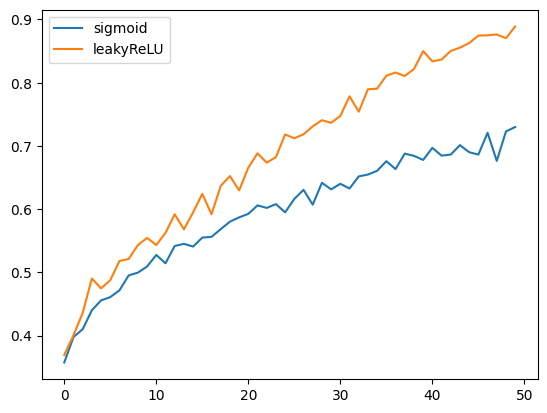

In [16]:
plot_acc(adam_sigmoid_train_acc_list, adam_train_acc_list, label1="sigmoid", label2="leakyReLU")

## [LOG] sigmoid와 leakyReLU의 train 정확도

## [MY CODE] Droupout 적용

In [17]:
from torch import nn


class DropoutModel(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout(x)
    x = self.act(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)

    return x


dropout_model = DropoutModel(32 * 32 * 3, 1024)
dropout_model = dropout_model.to('cuda')
dropout_optimizer = Adam(dropout_model.parameters(), lr=lr)

In [18]:
n_epochs = 50
dropout_train_acc_list = []
dropout_test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0
  dropout_model.train()

  for data in trainloader:
    dropout_model.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = dropout_model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    dropout_optimizer.step()

    total_loss += loss.item()


  # Append Accuracies
  dropout_train_acc_list.append(accuracy(dropout_model, trainloader))
  dropout_test_acc_list.append(accuracy(dropout_model, testloader))


  if epoch % 10 == 0:
    print(f"[Dropout] Epoch {epoch:3d} | Loss: {total_loss:.3f}")

[Dropout] Epoch   0 | Loss: 370.069
[Dropout] Epoch  10 | Loss: 266.014
[Dropout] Epoch  20 | Loss: 232.079
[Dropout] Epoch  30 | Loss: 202.822
[Dropout] Epoch  40 | Loss: 179.113


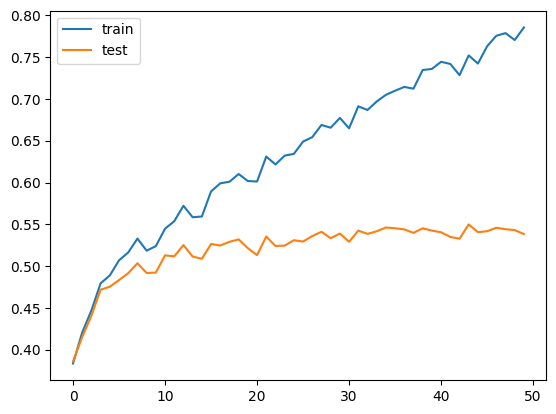

In [19]:
plot_acc(dropout_train_acc_list, dropout_test_acc_list, label1="train", label2="test")

## [FEEDBACK] loss와 정확도가 이 정도면 괜찮은지 궁금합니다.

loss가 82정도 나오는데, 정확도는 0.9에 수렴하고 있습니다.
이 정도 정확도면 충분한 것인지,
더 학습을 시키면 정확도가 증가하게 될지 과적합이 될지 궁금합니다.